In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas_profiling as pp
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

In [2]:
# Road raw training data
raw_data = pd.read_csv('data/train.csv', index_col=0)
raw_data.head(5)

# Drop weird data
# raw_data = raw_data.loc[~raw_data.index.isin([596, 399, 949, 342, 1188])]

# Create copy not to work on raw data
data = raw_data.copy()
data.shape

(1460, 80)

In [3]:
# Exclude columns with > 20% missing values
threshold = 0.2
data = data[data.columns[data.isnull().mean() < threshold]]
data.shape

(1460, 75)

Types of data:
- numerical
    - discrete (e.g. number of bathrooms, age)
    - continuous (e.g. temperature, weight)
- categorical (e.g. color, type of material)
- ordinal (e.g. rating, university grade)  

In [4]:
interval_columns = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                   'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                   'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                   'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
                   'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                   'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
fake_interval_columns = ['MSSubClass', 'OverallQual', 'OveralCond', 'MoSold']

interval_columns = list(set(interval_columns) - set(fake_interval_columns))

In [5]:
# Calculate "correlation" between features and target
corr = data.phik_matrix(interval_cols=interval_columns)

<AxesSubplot:>

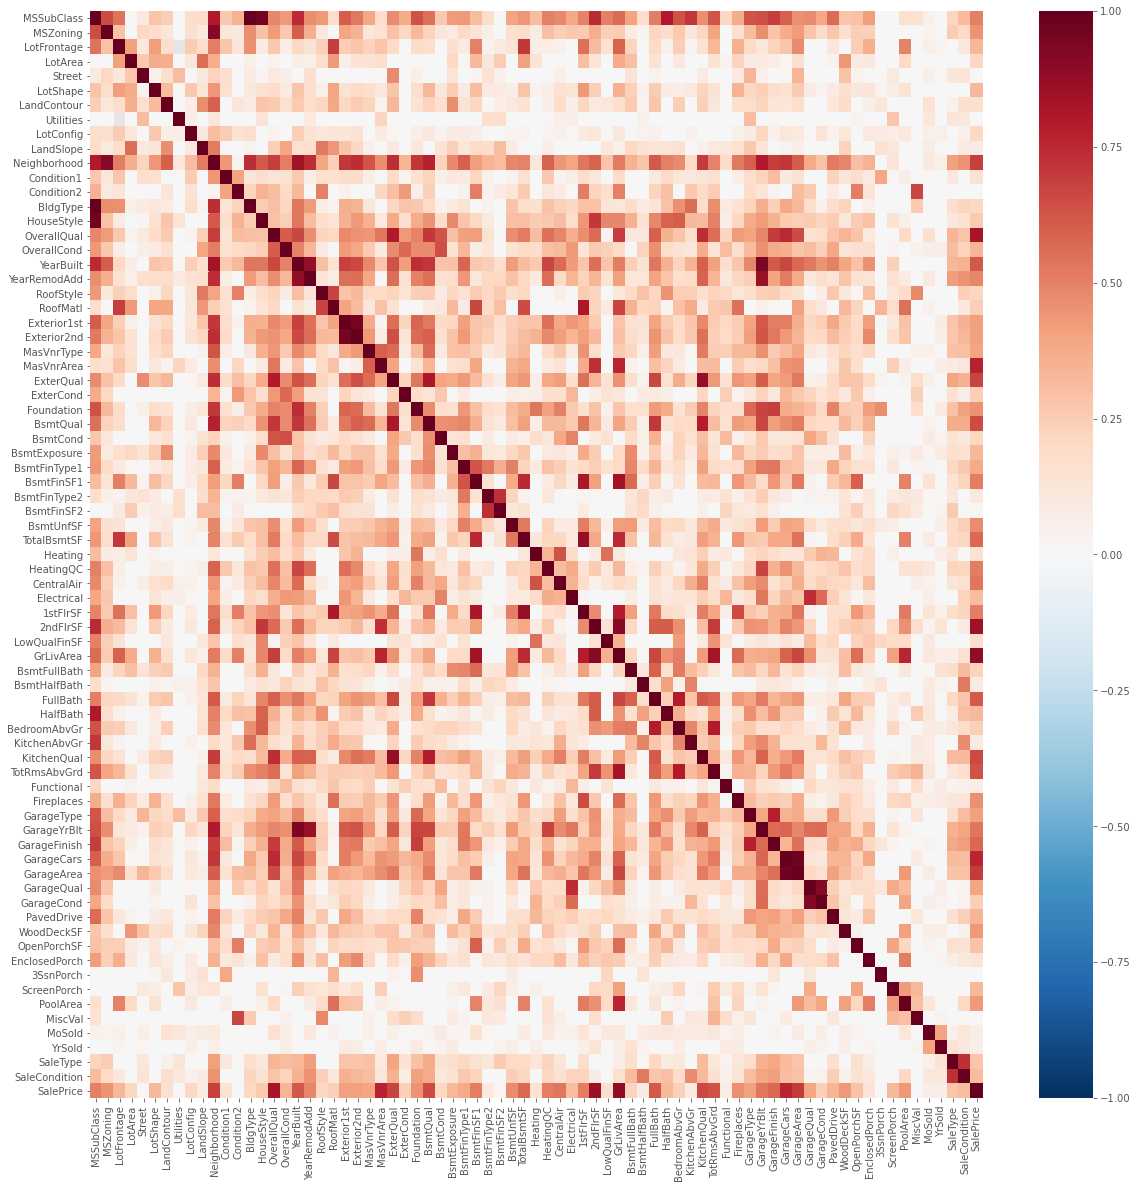

In [6]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')

Show only correlations between SalePrice (target) and all other features.

In [7]:
corr_price = corr["SalePrice"]

# Show features with highest correlation with price
corr_price = corr_price.sort_values(ascending=False)
corr_price.head(5)

SalePrice      1.000000
GrLivArea      0.887026
2ndFlrSF       0.854449
OverallQual    0.820348
MasVnrArea     0.770451
Name: SalePrice, dtype: float64

Remove unimportant features

In [8]:
correlation_threshold = 0.3
features_to_keep = corr_price[corr_price > correlation_threshold].index

# Remove features weakly correlating with target 
data = data[features_to_keep]
data.shape

data_filtered = data.copy()
data_filtered.shape

(1460, 44)

### Deal with categorical data

In [9]:
non_interval_columns = set(data.columns) - set(interval_columns)
data[non_interval_columns].dtypes

ordinal_columns = ['HeatingQC', 'GarageQual', 'BsmtFinType1', 'ExterQual', 
                   'GarageFinish', 'BsmtExposure', 'LotShape', 'OverallQual',
                   'BsmtQual', 'KitchenQual']
categorical_columns = list(set(non_interval_columns) - set(ordinal_columns))

In [10]:
# Use One Hot Encoding for categorical columns
for column in categorical_columns: 
    data = pd.get_dummies(data, columns=[column], prefix=column, prefix_sep='_', 
                          drop_first=True)

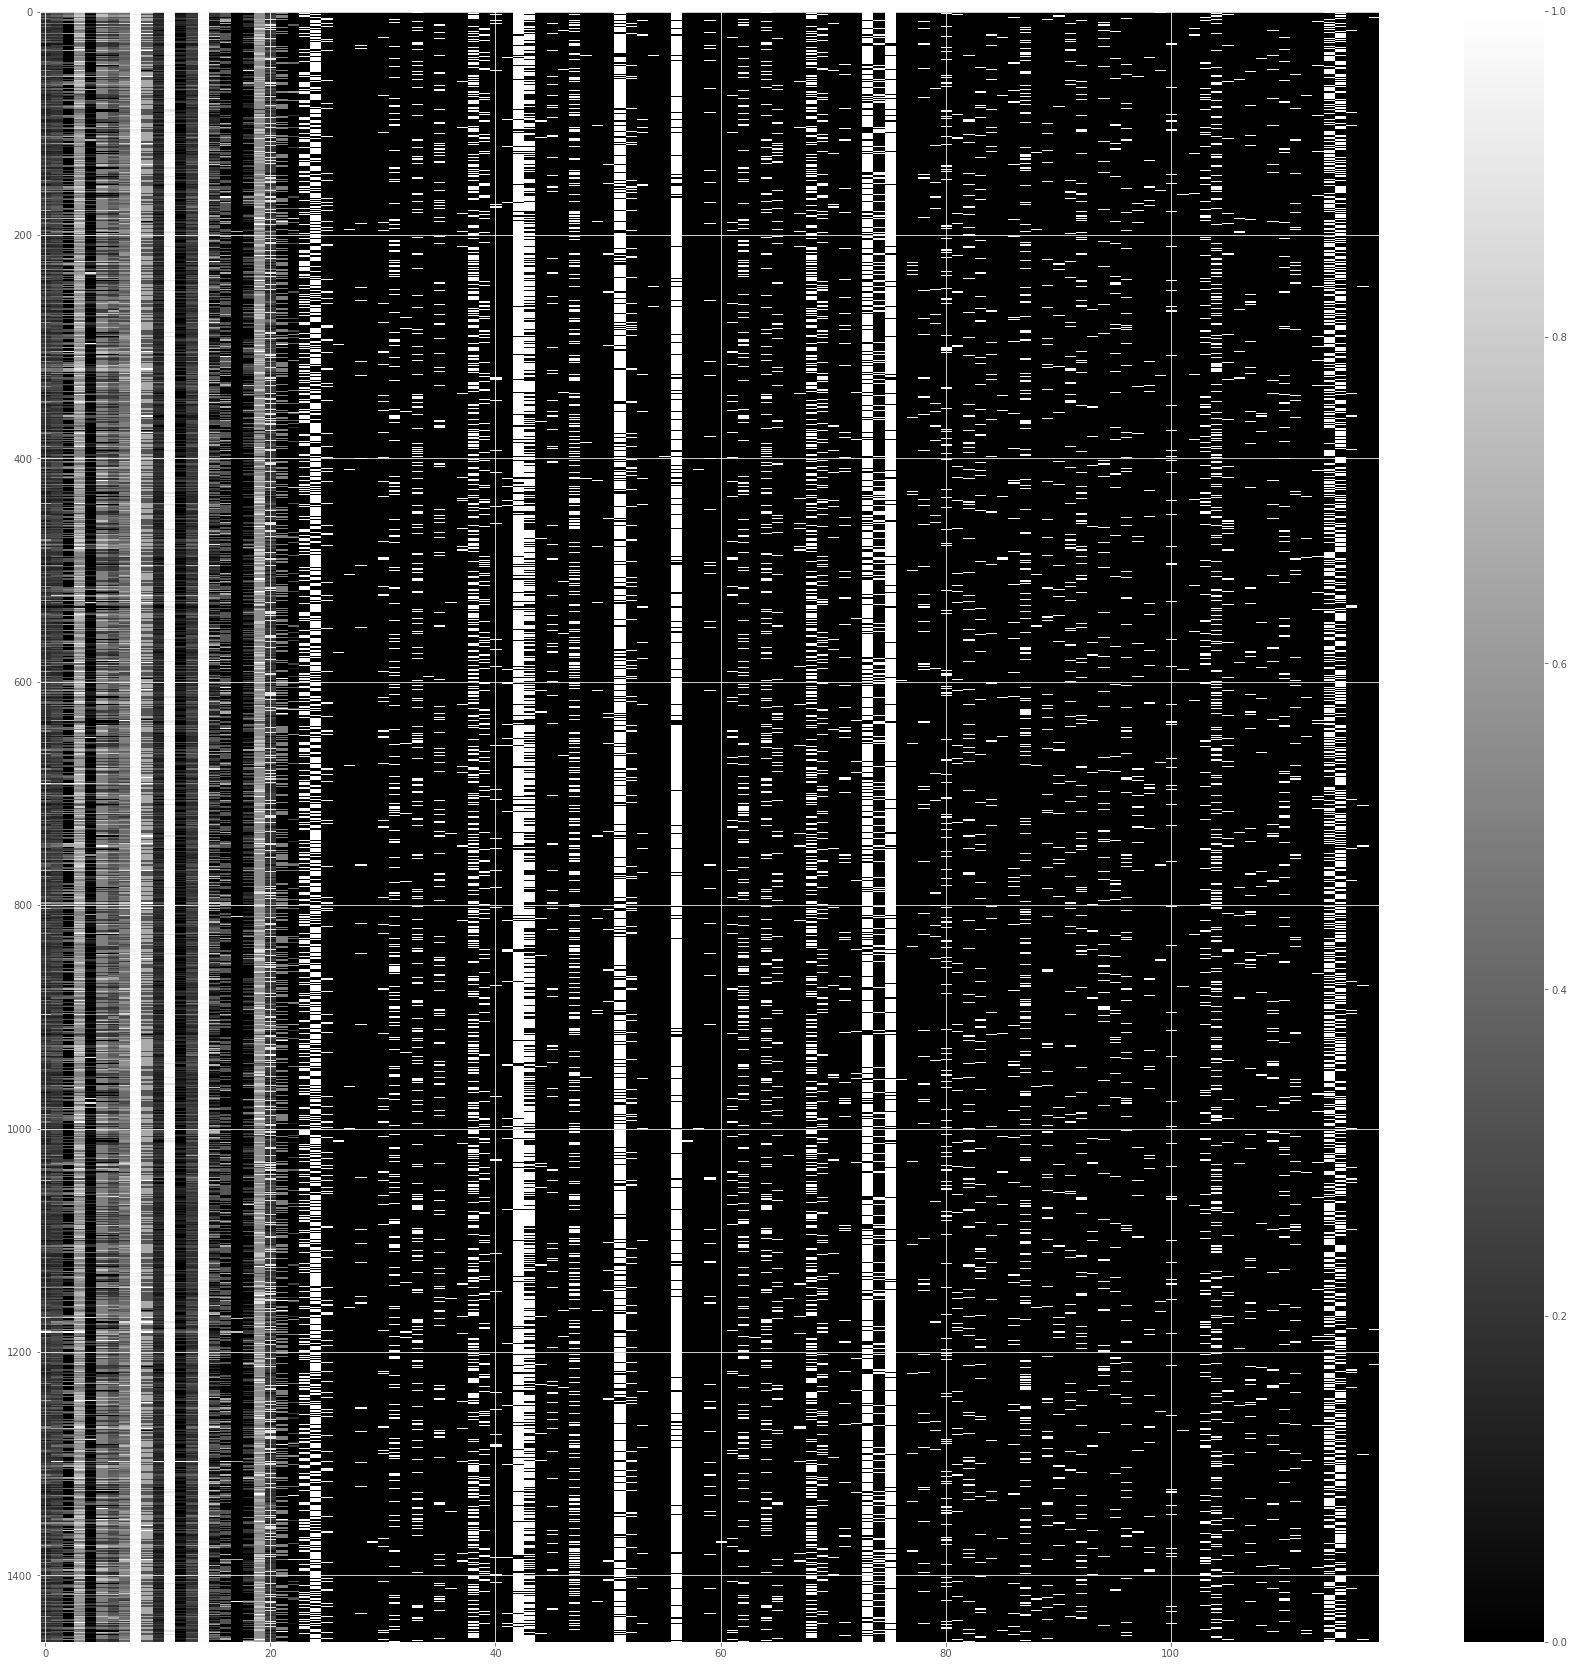

In [11]:
# Filter numerical data for visualisation purpose
df = data.select_dtypes(['number'])
df = 1 - ((df.max() - df) / df.max())

# Display numerical data
fig, ax = plt.subplots(figsize=(30, 30), facecolor='w')
im = ax.imshow(df.values, aspect='auto', interpolation='none', cmap='gray')
plt.colorbar(im);

### Deal with ordinal data

In [12]:
for c in data[ordinal_columns]:
    print(c, data[c].unique())

HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']


In [13]:
# Using def syntax
def nan_column(df, column):
    '''Creates column with ones and zeros encoding rows with nan.'''
    return ~df[column].isna().astype(int)

for column in ordinal_columns:
    if data[column].isna().any():
        print(f'Creating nan-encoding column for {column}')
        data[f'is{column}'] = nan_column(data, column)

Creating nan-encoding column for GarageQual
Creating nan-encoding column for BsmtFinType1
Creating nan-encoding column for GarageFinish
Creating nan-encoding column for BsmtExposure
Creating nan-encoding column for BsmtQual


```
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
```

In [14]:
def mapping_from_list(order):
    return {label: idx for idx, label in enumerate(order)}

# Features with ordinal data having same levels (Poor to Excelent)
quality_mapping = mapping_from_list([np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
quality_mapping_columns = ['HeatingQC', 'GarageQual', 'ExterQual', 'BsmtQual',
                           'KitchenQual']

for column in quality_mapping_columns :
    data[column] = data[column].map(quality_mapping)

# Other features with ordinal data having weird levels :D
data['LotShape'] = data['LotShape'].map(
    mapping_from_list([np.nan, 'IR3', 'IR2', 'IR1', 'Reg']))

data['BsmtFinType1'] = data['BsmtFinType1'].map(
    mapping_from_list([np.nan, 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']))

data['GarageFinish'] = data['GarageFinish'].map(
    mapping_from_list([np.nan, 'Unf', 'RFn', 'Fin']))

data['BsmtExposure'] = data['BsmtExposure'].map(
    mapping_from_list([np.nan, 'No', 'Mn', 'Av', 'Gd']))

In [15]:
data.select_dtypes(['number']).shape == data.shape

True

In [16]:
# Find numerical columns with remaining nan's 
nans_left = data.isna().sum() > 0
print(nans_left[nans_left])

data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

# Remove this feature because it is strongly correlated with YearBuilt
data = data.drop('GarageYrBlt', axis=1)

MasVnrArea     True
GarageYrBlt    True
LotFrontage    True
dtype: bool


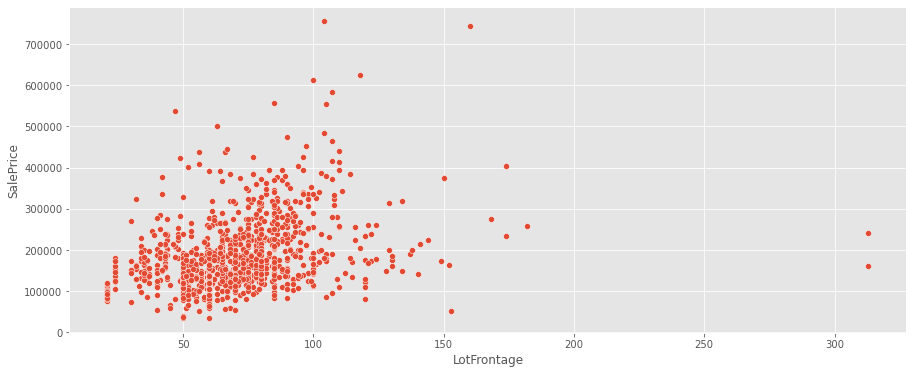

In [17]:
plt.figure(figsize=(15, 6), facecolor='w')
sns.scatterplot(
    x='LotFrontage',
    y='SalePrice',
    data=data,
)

# Impute nan's with mean, because we cannot assume 0 distance from street
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())

In [18]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

```python
>>> import numpy as np
>>> from sklearn.linear_model import LinearRegression
>>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_
3.0000...
>>> reg.predict(np.array([[3, 5]]))
array([16.])
```

In [19]:
reg = LinearRegression()
reg.fit(X_train_std, y_train)

LinearRegression()

In [20]:
# Predicting price of single house ("by hand")
np.sum(reg.coef_ * X_test_std[0]) + reg.intercept_

# ... or using model method
reg.predict(X_test_std)[0], y_test.iloc[0]

(105351.99475038068, 120500)

In [21]:
df = pd.DataFrame(
    data={
        'predicted': reg.predict(X_test_std),
        'real': y_test,
        'difference': (y_test - reg.predict(X_test_std)).abs(),
    }
)

df.loc[df['difference'] > y_test.max()]

,predicted,real,difference
Id,,,
575,-2.761924e+18,139000,2.761924e+18
299,-2.761924e+18,175000,2.761924e+18
596,-3.120197e+15,319000,3.120197e+15
399,-1.163125e+16,67000,1.163125e+16


In [22]:
df['difference'] > y_test.max()

Id
1437    False
58      False
781     False
383     False
1171    False
        ...  
510     False
556     False
400     False
546     False
267     False
Name: difference, Length: 438, dtype: bool

Weird price: -2.761923959286312e+18
Weird price: -2.7619239592862536e+18
Weird price: -3120196754238893.5
Weird price: -1.1631254316239196e+16


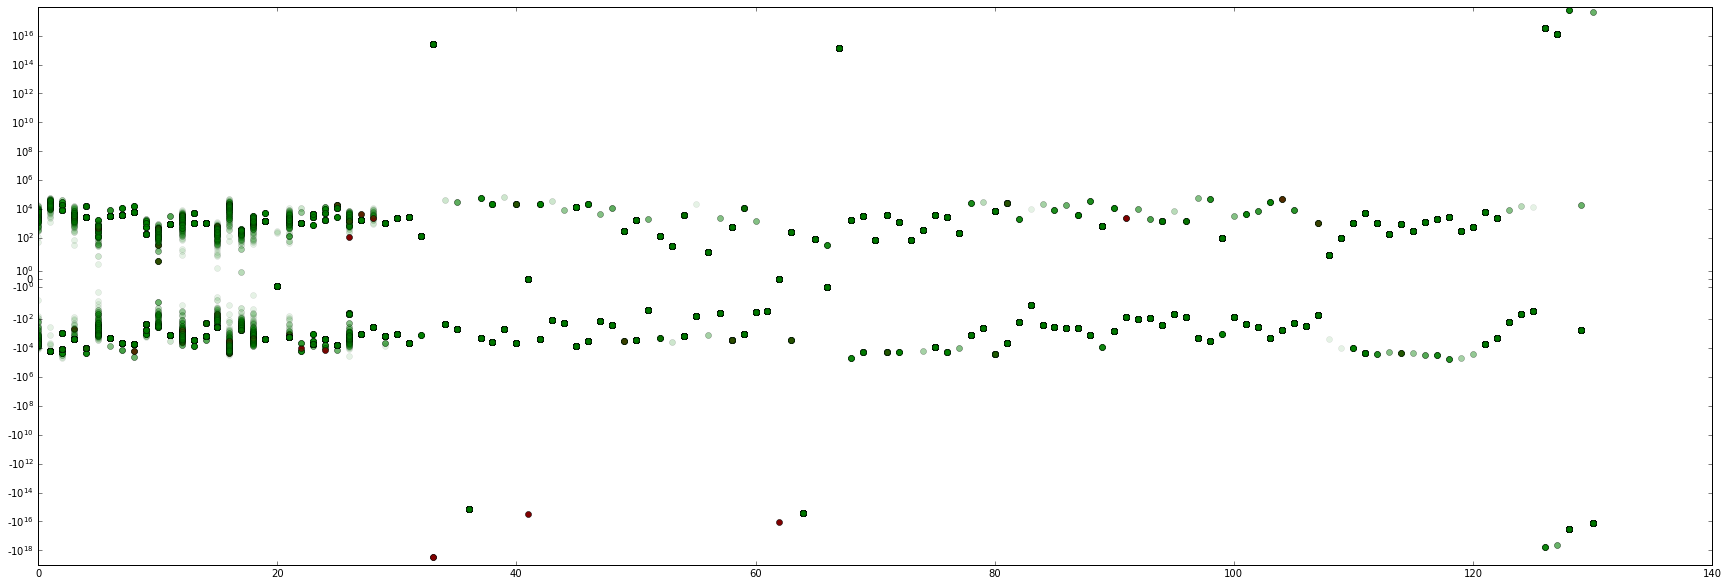

In [40]:
%matplotlib inline
# X_test_std * np.repeat(reg.coef_[np.newaxis, :], len(X_test_std), axis=0)
partial_prices = X_test_std * reg.coef_

plt.figure(figsize=(30, 10), facecolor='w')
for observation in partial_prices:
    if np.abs(np.sum(observation)) > y.max():
        print(f'Weird price: {np.sum(observation)}')
        color = 'maroon'
        alpha = 1
    else: 
        color = 'green'
        alpha = 0.1
    plt.plot(observation, 'o', color=color, alpha=alpha)
plt.yscale('symlog')
plt.show()

/home/kmb/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/kmb/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


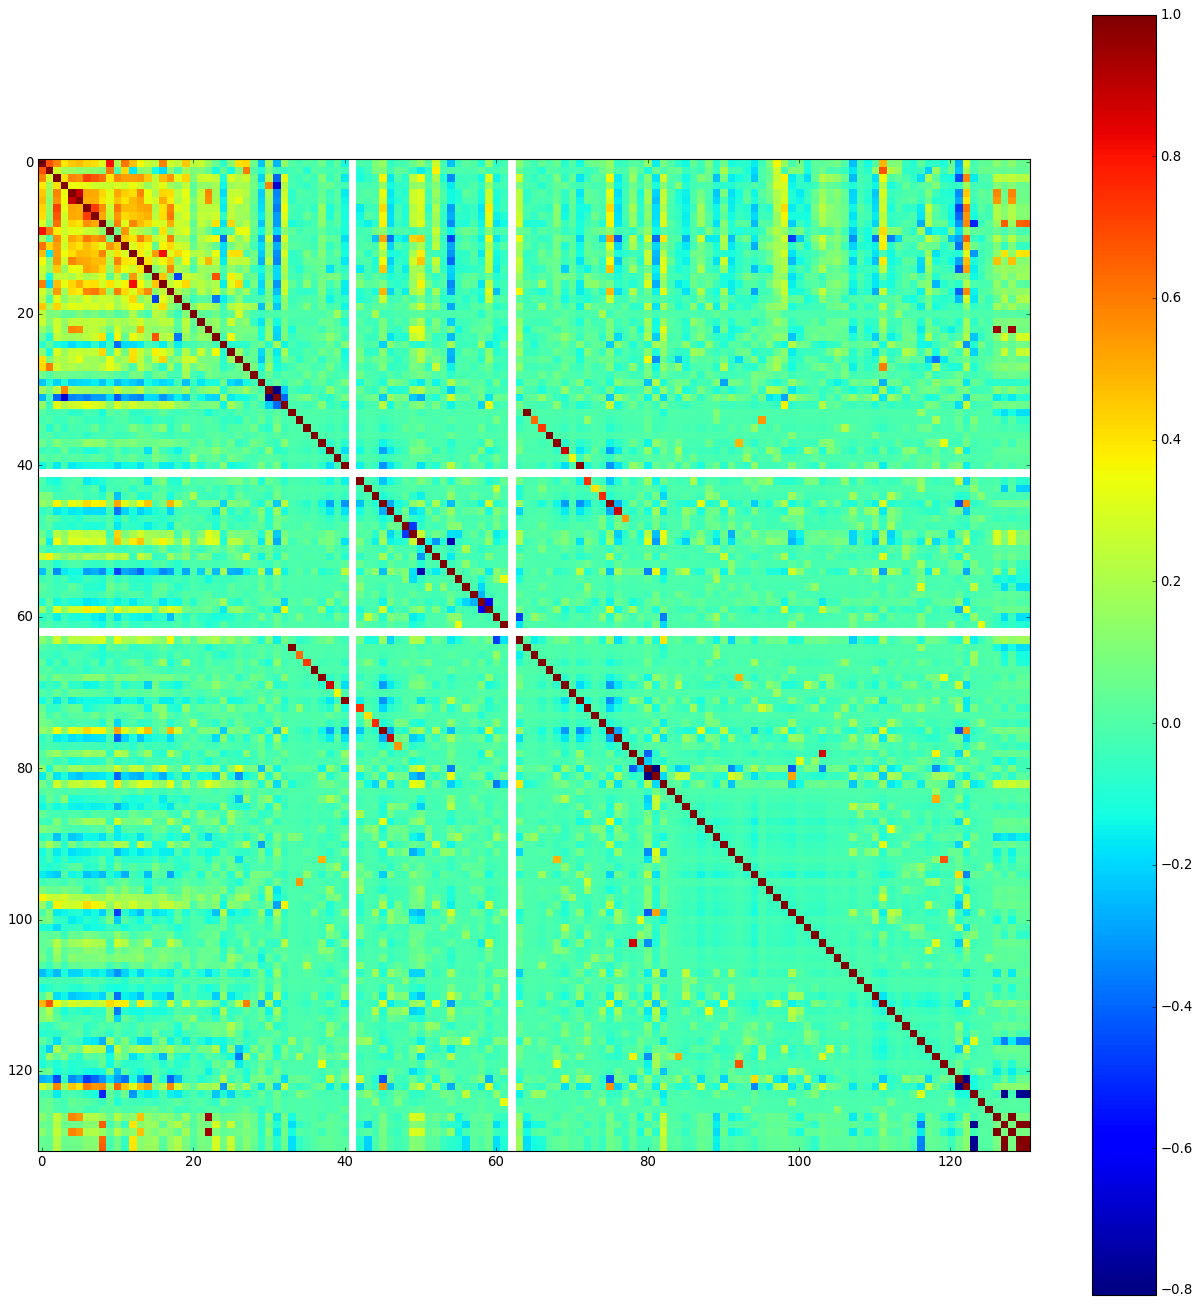

In [49]:
#['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
plt.style.use('classic')
plt.figure(figsize=(20, 20), facecolor='w')

corr = np.corrcoef(X_train_std.T)
im = plt.imshow(corr, interpolation='none')
plt.colorbar()

In [25]:
np.isnan(corr[0]).nonzero()

(array([41, 62]),)

In [26]:
data.iloc[:, [124]].sum()

Foundation_Slab    24
dtype: int64

In [27]:
profile = pp.ProfileReport(X_train.loc[:, np.abs(reg.coef_) > 1e10], title="Failed features")
profile.to_file("failed_features_report.html")

Text(0, 0.5, 'value')

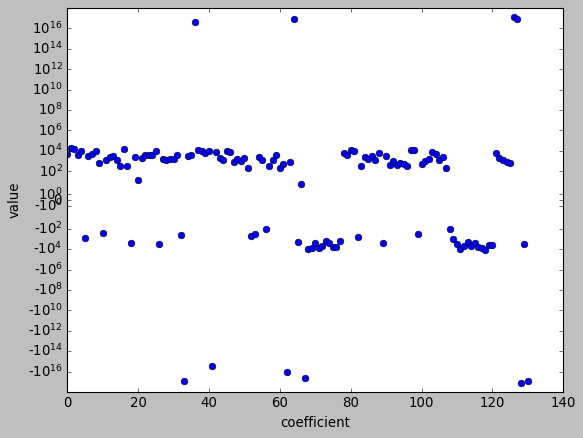

In [28]:
plt.plot(reg.coef_, 'o')
plt.yscale('symlog')
plt.xlabel('coefficient')
plt.ylabel('value')

# Homework

Find the reason for which $R^2$ drastically change after removing single records from test set!

## What is wrong?
- we should remove features that have two values 0 and 1 and only few houses have value of 1
- we should remove higly correlated features
- we should fix features starting with is... (wrong encoding)